# Kaggle Challenge: Human or Robot?
__Author: Dario Rocca__

This is a notebook to participate in the Kaggle competition 
https://www.kaggle.com/c/facebook-recruiting-iv-human-or-bot/data
<br>
In this competition it is necessary to idendify robots bidding in auctions. 
Three data files are provided:
<br>
1- train.csv: the training set from the bidder dataset
<br>
2- test.csv: the test set from the bidder dataset; no human/robot labels provided, indeed this file contains the bidders to be predicted
<br>
3- bids.csv: the bid dataset
<br>
The problem to address is the detection of robots that plague online auctions and frustrate humans users, which are plummeting. This is a classification problem whose classes are strongly unbalanced (a simple check on data shows 5% of robots on the total).
<br>
Kaggle private score obtained with the random forest algorithm in this notebook: 0.90671

## Loading libraries 

In [1]:
%pylab inline
import pandas as pd
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


## Loading data

The datafiles are loaded in the next frame.

In [2]:
# Loading the training set
# Columns:
# 1- bidder_id: Unique identifier of a bidder
# 2- payment_account: Payment account associated with a bidder. These are obfuscated to protect privacy. 
# 3- address – Mailing address of a bidder. These are obfuscated to protect privacy. 
# 4- outcome: Label of a bidder indicating whether or not it is a robot. 
# Value 1.0 indicates a robot, while value 0.0 indicates a human. 

train=pd.read_csv("train.csv")
print ""
print ("Some information on %s file" % "train.csv")
print ""
print train.info()
print ""
# All the objects are non-null

#Loading the test dataset
# This file has the same structure as train.csv without outcome (the human/robot label)
print ""
print ("Some information on %s file" % "test.csv")
print ""
test=pd.read_csv("test.csv")
print test.info()
print ""
# The test set has many more entries than the training set
# 4700 vs. 2013

# Loading the bid data set
# Columns:
# 1-bid_id: Unique id for this bid
# 2-bidder_id: Unique identifier of a bidder (same as the bidder_id used in train.csv and test.csv)
# 3-auction: Unique identifier of an auction
# 4-merchandise: The category of the auction site campaign
# 5-device: Phone model of a visitor
# 6-time: Time that the bid is made (transformed to protect privacy).
# 7-country: The country that the IP belongs to
# 8-ip: IP address of a bidder (obfuscated to protect privacy)
# 9-url: url where the bidder was referred from (obfuscated to protect privacy)
print ""
print ("Some information on %s file" % "bids.csv")
print ""
bids=pd.read_csv("bids.csv")
print bids.info()
print ""

# Let's drop bid_id that does not add any additional information 
bids = bids.drop(['bid_id'], axis=1)


Some information on train.csv file

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2013 entries, 0 to 2012
Data columns (total 4 columns):
bidder_id          2013 non-null object
payment_account    2013 non-null object
address            2013 non-null object
outcome            2013 non-null float64
dtypes: float64(1), object(3)
memory usage: 63.0+ KB
None


Some information on test.csv file

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4700 entries, 0 to 4699
Data columns (total 3 columns):
bidder_id          4700 non-null object
payment_account    4700 non-null object
address            4700 non-null object
dtypes: object(3)
memory usage: 110.2+ KB
None


Some information on bids.csv file

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7656334 entries, 0 to 7656333
Data columns (total 9 columns):
bid_id         int64
bidder_id      object
auction        object
merchandise    object
device         object
time           int64
country        object
ip             object
url  

## Data analysis and features engineering

### Data in train.csv

Let's take a look into the train.csv data.

In [3]:
# The following line of code is necessary to verify that the same account is not used 
# by multiple users 
# In principle this is trivial because each user is probably identified by the account
# Still this is also useful to verify data integrity
print ""
groupby_payment_account = train.groupby(['payment_account'])['bidder_id'].count()
print "Maximum number of bidders per account",groupby_payment_account.max()

# A similar double-check is done for the address
groupby_address = train.groupby(['address'])['bidder_id'].count()
print "Maximum number of bidders per address", groupby_address.max()
print ''


Maximum number of bidders per account 1
Maximum number of bidders per address 1



The previous part shows that there is not useful information included in payment_account and address as they have a 1 to 1 correspondence with the bidder_id. It might be possible to use them only by working on the decoding or by grouping parts of the coded strings; this is a time consuming task and as a first step it is better to start considering the abundant data in bids.csv

### Feature engineering from bids.csv: Total bids and unique values per bidder

In the next frame I look at the bids.csv file that contains important information. For example, a bidder that bids on a huge number of auctions might be more likely to be a robot (this is an hypothesis). The number of bids could be indeed an important feature. Other feautures can be built from other columns in the bids dataframe.

In [4]:
# As I will add features soon, a big dataframe that contains all the information is created.
# Indeed, since bids.csv contains bidders that might be both in train.csv and test.csv, it is
# useful to create a large dataframe that contains all the bidders. 
# Whenever needed this large dataframe can be split again.
# Setting the missing "outcome" column in test equal to 10 to distinguish it from train 

test['outcome']=10.0
tot= pd.concat([train, test], axis=0)
tot = tot.set_index('bidder_id')

######################################################################

#Grouping bids by bidder 
gbids = bids.groupby(['bidder_id'])

######################################################################

# The following lines allow us to detect bidders that bid on a large number of bids
# This might be an important feauture as a robot could place more bids than a human 

#n = total number
#pb = per bidder
tot['n_bids_pb'] = gbids['auction'].count()

print "Total number of bids for each bidder (first 10 lines)"
print ""
print tot['n_bids_pb'].head(10)
print ""
print "Maximum number of bids for a single bidder", tot['n_bids_pb'].max()
print ""

# Already from the first few lines of the series it is possible to notice some variability
# For example 0053b78cde37c4384a20d2da9aa4272aym4pb participated in as many as 10939 bids

######################################################################

# Similarly a robot might bid more than a human on many different auctions, on many different types of merchandise, 
# from many more different countries, etc.
# Let's create these feautures by identifying unique auctions, devices, etc for each bidder

list_nunique = ['auction','device','country','ip','url','merchandise']

# n = number of unique
# pb = per bidder
for c in list_nunique:
    nunstr = "n_" + c + "_pb"
    tot[nunstr] = gbids[c].nunique()
    print ""
    print "Maximum number of different "+c+" per bidder", tot[nunstr].max()
    print ""
    
######################################################################

print ""
print ""
print "Information on the tot dataframe with the new n_bids_pb, n_auction_pb, etc. features"
print ""
print tot.info()

Total number of bids for each bidder (first 10 lines)

bidder_id
91a3c57b13234af24875c56fb7e2b2f4rb56a     24.0
624f258b49e77713fc34034560f93fb3hu3jo      3.0
1c5f4fc669099bfbfac515cd26997bd12ruaj      4.0
4bee9aba2abda51bf43d639013d6efe12iycd      1.0
4ab12bc61c82ddd9c2d65e60555808acqgos1    155.0
7eaefc97fbf6af12e930528151f86eb91bafh      1.0
25558d24bca82beef0f9db4ba1fe2045ynnvq      8.0
88ae7a35e374a6fddd079ebb28c822eeohwse     34.0
57db69e32163f3e486dc6ef7d615aa12usje6      2.0
d1be739798ba0745a1fd72ac918a9f1929hei     14.0
Name: n_bids_pb, dtype: float64

Maximum number of bids for a single bidder 515033.0


Maximum number of different auction per bidder 1726.0


Maximum number of different device per bidder 2618.0


Maximum number of different country per bidder 178.0


Maximum number of different ip per bidder 111918.0


Maximum number of different url per bidder 81376.0


Maximum number of different merchandise per bidder 2.0



Information on the tot dataframe with the new n_

Two comments about the results of the previous dataframe: <br>
-Not much variability on the merchandise, as different bidders bid only
on maximum two different merchandises <br>
-The new features contain null values; that means that not all the bidders in test.csv and train.csv are in bids.csv

Before considering the engeneering of additional features let's consider some visulizations of the previous features


Scatterplots of Number of bids per bidder vs. Number of auction per bidder



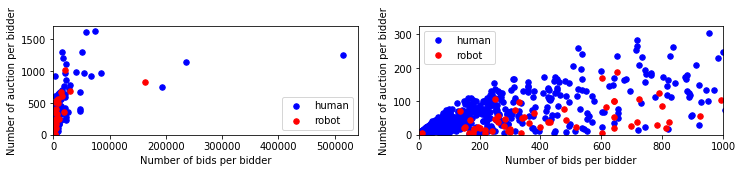


Scatterplots of Number of bids per bidder vs. Number of device per bidder



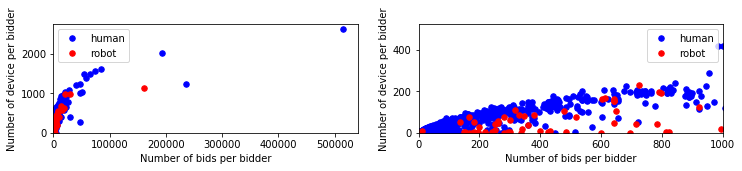


Scatterplots of Number of bids per bidder vs. Number of country per bidder



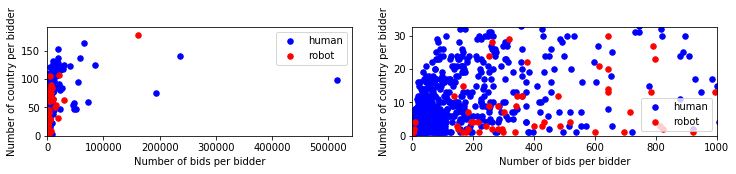


Scatterplots of Number of bids per bidder vs. Number of ip per bidder



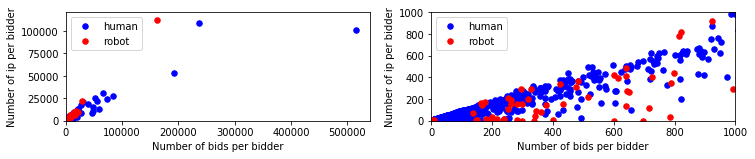


Scatterplots of Number of bids per bidder vs. Number of url per bidder



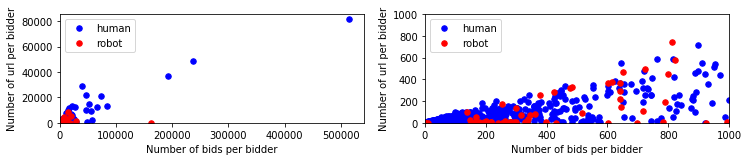


Scatterplots of Number of bids per bidder vs. Number of merchandise per bidder



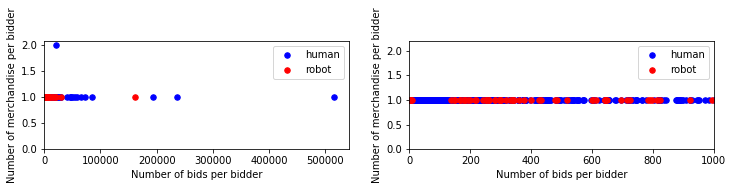


Scatterplots of Number of auction per bidder vs. Number of device per bidder



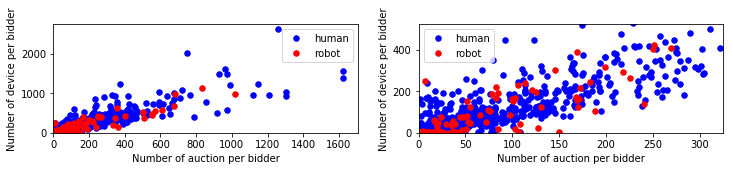


Scatterplots of Number of auction per bidder vs. Number of country per bidder



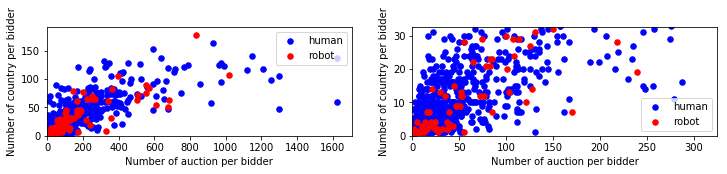


Scatterplots of Number of auction per bidder vs. Number of ip per bidder



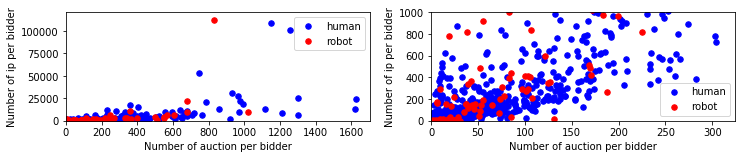


Scatterplots of Number of auction per bidder vs. Number of url per bidder



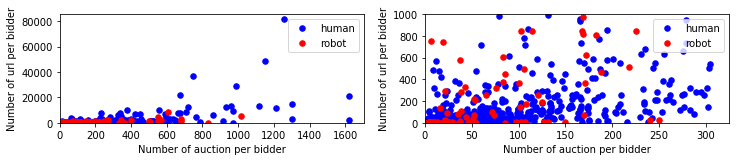


Scatterplots of Number of auction per bidder vs. Number of merchandise per bidder



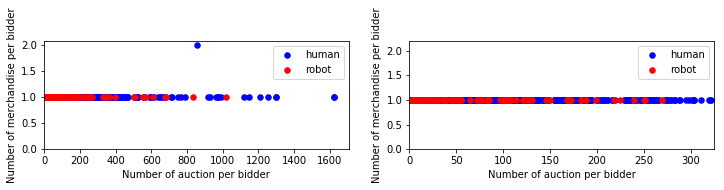


Scatterplots of Number of device per bidder vs. Number of country per bidder



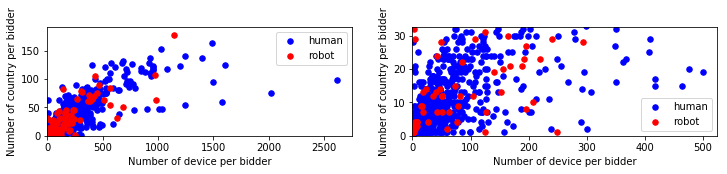


Scatterplots of Number of device per bidder vs. Number of ip per bidder



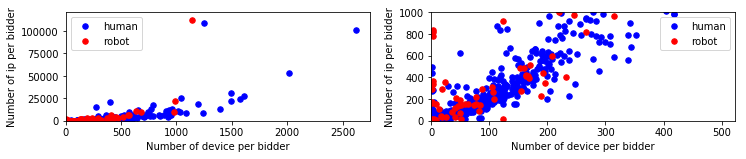


Scatterplots of Number of device per bidder vs. Number of url per bidder



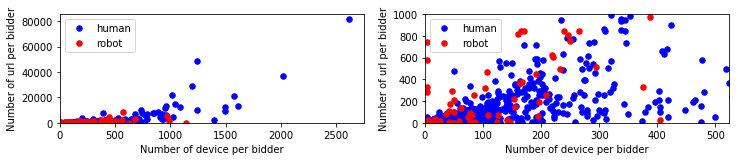


Scatterplots of Number of device per bidder vs. Number of merchandise per bidder



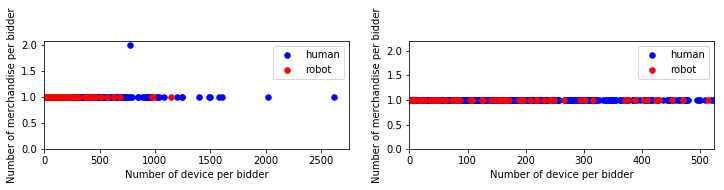


Scatterplots of Number of country per bidder vs. Number of ip per bidder



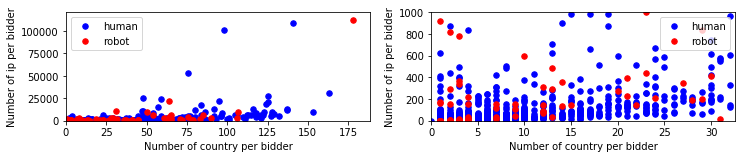


Scatterplots of Number of country per bidder vs. Number of url per bidder



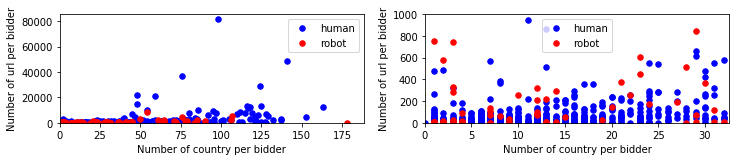


Scatterplots of Number of country per bidder vs. Number of merchandise per bidder



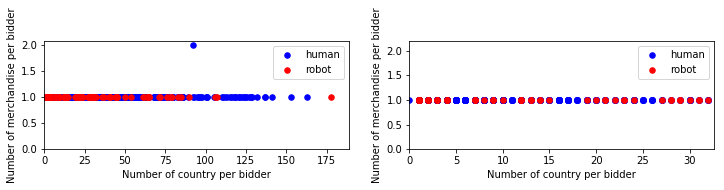


Scatterplots of Number of ip per bidder vs. Number of url per bidder



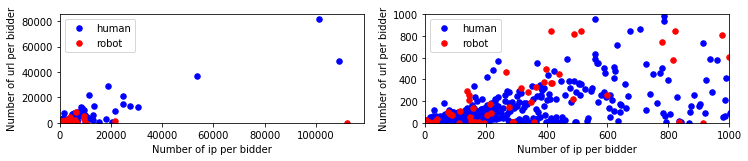


Scatterplots of Number of ip per bidder vs. Number of merchandise per bidder



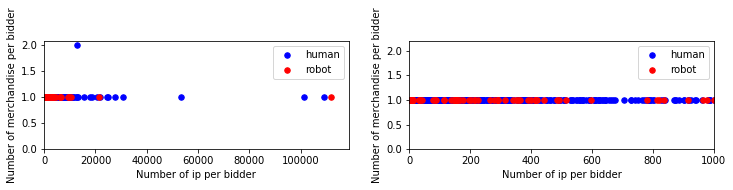


Scatterplots of Number of url per bidder vs. Number of merchandise per bidder



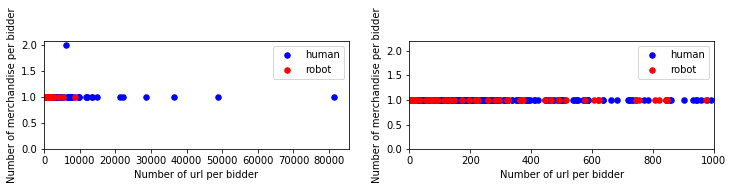

In [5]:
#From the tot dataframe I extract two dataframes corresponding to humans and robots 
plt_h = tot.loc[tot['outcome'] == 0.0].copy() #Humans
plt_r = tot.loc[tot['outcome'] == 1.0].copy() #Robots

#Function to scatter plot pairs of the previously created features
#Different colors for humans and robots
def scatterplot_human_robot(humanx,humany,robotx,roboty,labelx,labely):
    #
    # This function creates 2 scatter plot side by side
    # 1st plot: Full range, useful to see overall behavior and outliers
    # 2nd plot: Smaller range
    #
    plt.figure(figsize=[12,2])
    #
    # 1st plot
    #
    plt.subplot(121)
    plt.scatter(humanx,humany,label='human', s=30., c='b')
    plt.scatter(robotx,roboty,label='robot', s=30., c='r')
    #
    xlim(xmin=0)
    ylim(ymin=0)
    #
    plt.xlabel(labelx)
    plt.ylabel(labely)
    plt.legend()
    #
    # 2nd plot
    #
    plt.subplot(122)
    plt.scatter(humanx,humany,label='human', s=30., c='b')
    plt.scatter(robotx,roboty,label='robot', s=30., c='r')
    #
    plt.xlabel(labelx)
    plt.ylabel(labely)
    plt.legend()
    #
    if max(humanx)>=5000:
        xmax=1000
    elif (max(humanx)>5 and max(humanx)<5000):
        xmax=max(humanx)/5.0
    else:
        xmax=max(humanx)+0.2
    #
    if max(humany)>=5000:
        ymax=1000
    elif (max(humany)>5 and max(humany)<5000):
        ymax=max(humany)/5.0
    else:
        ymax=max(humany)+0.2
    #
    xlim([0,xmax])
    ylim([0,ymax])
    #
    plt.show()
    #
    return

# Since the number of features is still limited I will consider them all 
list_plot1 = ['bids','auction','device','country','ip','url','merchandise']
list_plot2 = ['auction','device','country','ip','url','merchandise']

# Loop over all the possible combinations of the features
for x in list_plot1:
    for y in list_plot2:
        #
        # Dataframe columns
        sx = "n_" + x + "_pb"
        sy = "n_" + y + "_pb"
        #
        # Axis labels
        lx = "Number of " + x + " per bidder"
        ly = "Number of " + y + " per bidder"
        #
        print ""
        print "Scatterplots of " + lx + " vs. " + ly 
        print ""
        #
        scatterplot_human_robot(plt_h[sx],plt_h[sy],plt_r[sx],plt_r[sy],lx,ly)
        #
        # Let's eliminate the first element of list_plot2 to avoid duplication
    if list_plot2:
        list_plot2.pop(0)


From the previous visualization it is clear that a simpe linear separation of human and robots will have limited reliability by using only these features. Still there are some interesting trends. For example the plot "Number of bids per bidder vs. Number of device per bidder" shows that several robots tend to use fewer devices than humans.

### Feature engineering from bids.csv: Bids per user from each different country

A large number of features can be created by considering the bids per user from each different country (a column is introduced for each different country with the number of bids per bidder from that country). It is for example possible that robots tend to bid more from a subset of countries. Similar features could be built for auction and maybe also for ip and url. In this case the number of features would be orders of magnitude larger than the number of training examples; this might easily lead to overfitting, beyond being computationally cumbersome. For the moment I consider only the case of the bids per user from each different country.

In [6]:
# Below I create a dataframe country with columns corresponding to each country;
# each one of these columns contains the number of bids for each bidder from that country.
# In order to build this dataframe: 
# (1) I create dummy variables for the categorical variable country from the dataframe bids; 
# (2) Then I drop the columns that don't correspond to countries;
# (3) Finally I group by bidder_id and sum the values.

country=pd.get_dummies(data=bids,drop_first=False,columns=['country'])                # (1)
country = country.drop(['auction','device','time','merchandise','ip','url'], axis=1)  # (2)
country = country.groupby(['bidder_id']).sum()                                        # (3)

# Uncomment to do the same thing with merchandise
#merchandise = pd.get_dummies(data=bids,drop_first=False,columns=['merchandise'])
#merchandise = merchandise.drop(['auction','device','time','country','ip','url'], axis=1)
#merchandise = merchandise.groupby(['bidder_id']).sum()

Let's consider some visualization of the previous data. Specifically I would like to see the country preferences of robots and humans.


Plots of the average number of bids vs. country

Top 10 countries with the highest average of bids for humans


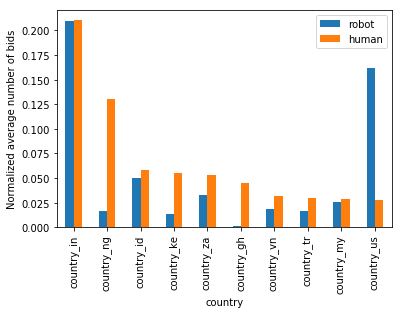


Top 10 countries with the highest average of bids for robots


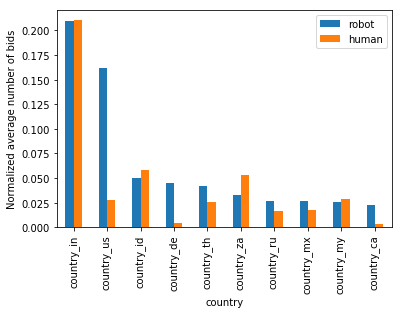

In [7]:
#Since I want to separate robots and humans I add the column 'outcome' to country dataframe 
#and create the new dataframe country_out
country_out = pd.concat([country, tot['outcome']], axis=1)

#I seperate humans (0) and robots (1) in two dataframes
country_h = country_out.loc[country_out['outcome'] == 0.0].copy() #Humans
country_r = country_out.loc[country_out['outcome'] == 1.0].copy() #Robots

#I create two series for humans and robots that contain the country as index and the normalized average number of 
#bids from that country as value
#I introduced a normalization (sum of averages will give 1) to have a more balanced comparison human/robot
# as overall robots bid on average more than humans 
country_mean_h = country_h.mean()/country_h.mean().sum()
country_mean_r = country_r.mean()/country_r.mean().sum()

#In order to be able to manipulate the two series country_mean_h and country_mean_r
#at the same time I merge them in the dataframe mean_hr
mean_hr = pd.concat([country_mean_h, country_mean_r], axis=1)
mean_hr.columns=['human','robot']
mean_hr['country']=mean_hr.index

#I now barplot the averages for the top 10 countries with the highest average (there are 200 countries)
print ""
print "Plots of the average number of bids vs. country"
print ""

n_to_plot = 10

print "Top "+ str(n_to_plot) +" countries with the highest average of bids for humans"
mean_hr.sort_values(by=['human'],ascending=False).head(n_to_plot).plot(x='country', y=['robot', 'human'],kind='bar')
plt.ylabel("Normalized average number of bids")
plt.show()

print ""
print "Top "+ str(n_to_plot) +" countries with the highest average of bids for robots"
mean_hr.sort_values(by=['robot'],ascending=False).head(n_to_plot).plot(x='country', y=['robot', 'human'],kind='bar')
plt.ylabel("Normalized average number of bids")
plt.show()


Remarks about the previous plots: <br>
-To a large extent the top 10 countries used to bid by humans and robots are different; <br>
-A strong difference in the bar height indicates that one group strongly "prefer" one country with respect to the other group. For example robots "prefer" the USA (us), Germany (de), Canada (ca) more than humans; <br>
-__Warning__: From the previous plots I cannot conclude for example that a bidder which bids from Germany (de) is almost for sure a robot. In the previous plots I presented averages; since humans are many more than robots in number they could still overpower them in the absolute value of bids from Germany. 

From what shown in the previous plots the country information might help our model and below I add the country dataframe to the the main dataframe tot.

In [8]:
tot = pd.concat([tot, country], axis=1)

### Feature engineering from bids.csv: Time related features

In the next few frames I will consider the time variable, which requires special care. The time has been "transformed" and it cannot be easily interpreted.
<br>
Let's start by visualizing the bid activity corresponding to a certain time.

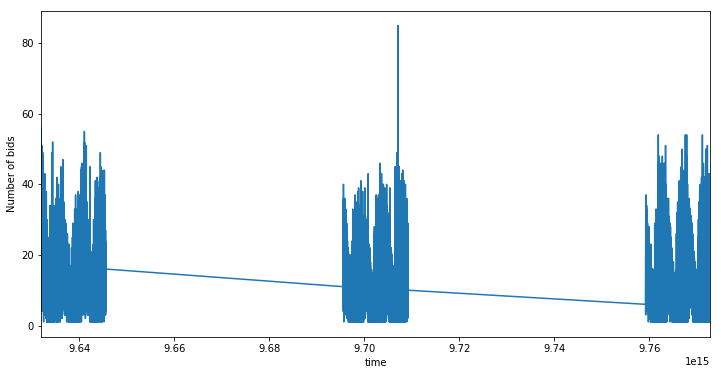

In [9]:
bids_time = bids.groupby(['time'])['auction'].count()

plt.figure(figsize=[12,6])
plt.ylabel("Number of bids")
bids_time.plot()

The number of bids per each time are grouped in three clusters with some internal periodicity, which is not easy to interpret. If I consider each "chunk" as a single day I could consider that there is a spike in the opening
in the morning and drops in the middle of the morning, lunch, and mid-afternoon. With this interpretation the separation between clusters seems too long. Other interpretations are possible.
<br>
It might be safer to stick to the given "transformed time" for feature engineering.

I first create two features: (1) max_st: Maximum number of bids placed at the same time for each bidder (2) n_diff_t: Number of unique times at which the bids were placed for each bidder (this is not not very different from the features created earlier starting from the categorical variables)

In [10]:
#Can a single bidder (human or bot) place multiple bids at the same time? Yes!
max_st_pb = bids.groupby(['bidder_id','time'])['auction'].count()
print ""
print "Maximum number of bids placed exactly at the same time by the same bidder: ", max_st_pb.max()
print ""

#A new feature: Maximum number of bids placed at the same time for each bidder
max_st=max_st_pb.groupby(level=['bidder_id']).max()

#Number of unique times at which the bids were placed for each bidder
n_diff_t = bids.groupby(['bidder_id'])['time'].nunique()


Maximum number of bids placed exactly at the same time by the same bidder:  30



The following features are related to delta t (dt), namely the difference between one bid time and the previous one for the same bidder. Below I create two features: <br>
(1) bidder_mean_dt, the mean of delta t for each bidder; for example, it is possible that robots are faster than humans <br> 
(2) bidder_std_dt, the standard deviation of delta t for each bidder; for example, it is possible that robots are more "regular", and so there is less dispersion in the delta t's <br>
Not for all the bidders there is enough data to compute a statistically reliable mean or std; still I believe that these features could help. 

In [11]:
####
# This line creates a series where times are sorted in ascending order for each bidder_id
# This will avoid possible issues if the time data are not properly sorted
bidder_sorted_t = bids.groupby('bidder_id').apply(lambda x:x.sort_values('time'))['time']

# This line computes delta t = difference of time between consecutive bids of a bidder
# Lots of NaN values will be produced as several bidders bid only ones
bidder_delta_t = bidder_sorted_t.groupby(level='bidder_id').apply(lambda x:x-x.shift())

# We have now to pay attention: If a bidder bids across two time clusters (see previous figure)
# some of the delta t values might be too large and bias the mean and standard deviation.
# Let's remove these outliers (the 0.02e15 value is deduced from the previous plot)
bidder_delta_t=bidder_delta_t[bidder_delta_t<0.02e15]
# The outliers' removal is reasonable: we want the bidder reaction time within each time cluster,
# which should not be influenced by the periods in which the auctions are shut down 

# This line computes the mean of delta t for each different bidder
# .mean() will discard the NaN's unless there is only one value = to NaN 
# bidder_mean_dt will be a feature used in the ML model 
bidder_mean_dt = bidder_delta_t.groupby(level='bidder_id').mean()

# This line computes the standard deviation of delta t for each different bidder
# bidder_std_dt will be a feature used in the ML model
bidder_std_dt = bidder_delta_t.groupby(level='bidder_id').std()

#Uncomment the following lines to print some information about the previous series  

# print "Series where times are sorted in ascending order for each bidder_id"
# print ""
# print bidder_sorted_t.head(20)

# print ""
# print "Series that condains delta t (difference of time between consecutive bids of a bidder)"
# print ""
# print bidder_delta_t.head(20)
# print ""

# print ""
# print "Series that condains the mean of delta t for each different bidder"
# print ""
# print bidder_mean_dt.head(20)
# print ""

# print ""
# print "Series that condains standard deviation of delta t for each different bidder"
# print ""
# print bidder_std_dt.head(20)
# print ""

Adding the previous features to the dataframe tot and some visualizations of the delta t features

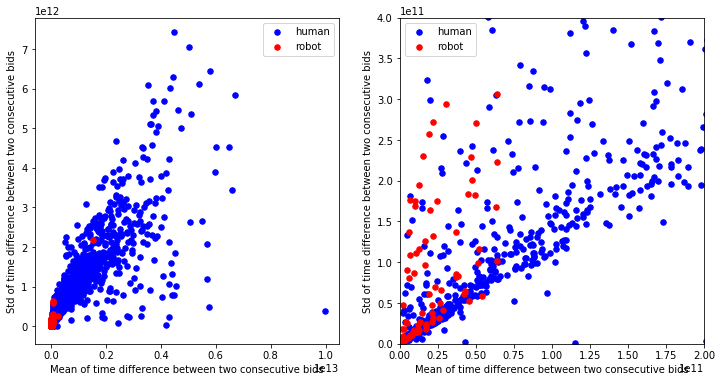

In [12]:
#Adding to tot dataframe
tot['max_st']=max_st
tot['n_diff_t']=n_diff_t
tot['bidder_mean_dt']=bidder_mean_dt
tot['bidder_std_dt']=bidder_std_dt

#Scatterplot of bidder_mean_dt vs. bidder_std_dt
#Splitting humans and robots
pl_h = tot.loc[tot['outcome'] == 0.0].copy() #Humans
pl_r = tot.loc[tot['outcome'] == 1.0].copy() #Robots

plt.figure(figsize=[12,6])

#We have to pay attention: Since some bidders might bid only few times (1 or 2) the
#mean and/or std of dt can be NaN for several bidders
#The following commented lines allow for a quick and dirty 
#visualization of the NaNs; 
#pl_h['bidder_mean_dt']=pl_h['bidder_mean_dt'].fillna(1e13)
#pl_h['bidder_std_dt']=pl_h['bidder_std_dt'].fillna(1e13)
#pl_r['bidder_mean_dt']=pl_r['bidder_mean_dt'].fillna(1.2e13)
#pl_r['bidder_std_dt']=pl_r['bidder_std_dt'].fillna(1.2e13)

#print "Null robot values in bidder_mean_dt", pl_r['bidder_mean_dt'].isnull().sum()
#print "Null robot values in bidder_std_dt", pl_r['bidder_std_dt'].isnull().sum()

#There are 5 robots that barely bid with null bidder_mean_dt and bidder_std_dt

# 1st plot on the full range
plt.subplot(121)
plt.scatter(pl_h['bidder_mean_dt'],pl_h['bidder_std_dt'],label='human', s=30., c='b')
plt.scatter(pl_r['bidder_mean_dt'],pl_r['bidder_std_dt'],label='robot', s=30., c='r')
plt.xlabel('Mean of time difference between two consecutive bids')
plt.ylabel('Std of time difference between two consecutive bids')
plt.legend()
#plt.show()

# 2nd plot on a smaller range 
plt.subplot(122)
plt.scatter(pl_h['bidder_mean_dt'],pl_h['bidder_std_dt'],label='human', s=30., c='b')
plt.scatter(pl_r['bidder_mean_dt'],pl_r['bidder_std_dt'],label='robot', s=30., c='r')
plt.xlabel('Mean of time difference between two consecutive bids')
plt.ylabel('Std of time difference between two consecutive bids')
plt.legend()
xlim([0,0.02e13])
ylim([0,0.04e13])
plt.show()

__Very interesting:__ robots have ideed small mean and std for delta t (difference in time between consecutive bids). A huge outlier is present, I might consider removing it later when traing the model. Also 5 robots barely bid; they are probably misclassified in the train set or anyway outliers. <br>

__However__, the mean and std features are null for several bidders but rarely for robots, which bid on average more than humans and so produce enough statistics. Below I will replace the NaN values of mean and std to a reasonable value.  

## Model selection and predictions

### Removing outliers and filling in null values

I drop the two columns which contain strings

In [13]:
tot=tot.drop('payment_account',axis=1)
tot=tot.drop('address',axis=1)

The tot dataframe contains null values, which are not well-digested by some ML algorithms. Below I eliminate some of these null values and also some outliers.

In [14]:
# Let's pepare the tot dataframe for the ML model
#print "Null values"
#print tot.isnull().sum()

# I prefer to remove the outliers with more than 100k bids in the training part
tot = tot.drop(tot[(tot['n_bids_pb'] > 100000) & (tot['outcome']<9.0)].index)

# Removing also robot outliers that don't bid and
# the robot which is a bidder_mean_dt/bidder_std_dt outlier (see previous plot)
tot = tot.drop(tot[(tot['bidder_std_dt'].isnull()) & (tot['outcome']==1.0)].index)
tot = tot.drop(tot[(tot['bidder_std_dt'] > 1e12) & (tot['outcome']==1.0)].index)

# Since the country_xx columns are very sparse I will replace the missing values with zeros
for st in tot.columns:
    if ('country' in st) and (st != 'n_country_pb'):
        tot[st] = tot[st].fillna(0)
        
# We now deal with the missing bidder_mean_dt and bidder_std_dt
# There are several of them null (>1000)
# However there is an advantage: These data are rarely missing for robots
# Accordingly, I propose to replace them with the average human value 

mean_tmp = tot[tot['outcome']==0.0].groupby('outcome')['bidder_mean_dt'].mean()[0] 
std_tmp = tot[tot['outcome']==0.0].groupby('outcome')['bidder_std_dt'].mean()[0]
tot['bidder_mean_dt'] = tot['bidder_mean_dt'].fillna(mean_tmp)
tot['bidder_std_dt'] = tot['bidder_std_dt'].fillna(std_tmp)

For all the remaining null values I will use the Scikit learn Imputer with column mean. This operation will be done later, when the tot dataframe will be split in train-test-predict to prevent data leakage  

I (re)create the train dataframe, which contains the bidders in the original file train.csv and the predict dataframe, which contains the bidders in test.csv (the bidders to be predicted). 

In [15]:
#Training test set (as a reminder 'outcome'=10.0 was used to denote the bidders with no human/robot label)

train = tot.loc[tot['outcome'] < 9.0].copy()
predict = tot.loc[tot['outcome'] == 10.0].copy()

### Random Forest Prediction

Using the random forest classifier. I keep 20% of the labeled data (train.csv) for testing. With the remaining I used 4-fold cross validation for the grid search of the parameters. Classes in the data are strongly unbalanced: in train.csv only ~5% of the bidders is a robot. A simple 'accuracy' scorer is for sure not a good one. As the Kaggle ranking is determined by the area under the ROC curve, I used 'roc_auc' for model evaluation. I printed also precision, recall, and f1-score. 

In [16]:
# Importing sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.preprocessing import Imputer


X = train.drop("outcome",axis=1) # Training vectors
y = train["outcome"] # Target values

# As I have only target values (robot:1 - human:0) in train.csv
# I need to keep 20% of these data aside as a test set 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

X_predict = predict.drop("outcome",axis=1) # Vectors for prediction
bid_id = X_predict.index                   # Used later to print the predictions

# The Imputer is used to fill in the remaining NaN's with means
impt = Imputer(missing_values='NaN', strategy='mean', axis=0)

# To prevent data leakage I fit the imputer to X_train and 
# then use the same parameters for X_test and X_predict 
impt.fit(X_train)
X_train = impt.transform(X_train)
X_test = impt.transform(X_test)
X_predict = impt.transform(X_predict)


####### The following commented lines have been used to optimize the RandomForestClassifier parameters
####### This takes some time 

## Important parameters to optimize: n_estimators, max_features, and max_depth
# search_grid_rf = [{'n_estimators': [10, 20, 40, 80, 100, 120],
#                 'max_features': [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7],
#                 'max_depth': [2, 4, 8, 12, 14, 16, 18, None]}]

# clf_rf = GridSearchCV(RandomForestClassifier(random_state=0), search_grid_rf, cv=4,
#                        scoring='roc_auc')

# clf_rf.fit(X_train, y_train)

# print "Best parameters set found on traning set:"
# print ""
# print clf_rf.best_params_
# print ""
# print "Grid scores on training set:"
# print ""
# for params, mean_score, scores in clf_rf.grid_scores_:
#     print("%0.3f (+/-%0.03f) for %r"
#             % (mean_score, scores.std() * 2, params))
# print ""

################################################################################

# The classifier
clf_rf = RandomForestClassifier(max_features = 0.1, n_estimators = 100, max_depth = 14, random_state=0)
# With the parameters above I got 0.936+-0.007 as best score in the grid search
# random_state=0 allows for reproducibility; alternatively we could release this constraint 
# and average over different final results

# Fitting the classifier
clf_rf.fit(X_train, y_train)

# Printing precision, recall, etc. with respect to the test set 
print "Detailed classification report:"
print ""
print "The model is trained on the training set."
print("The scores are computed on the test set.")
print ""
y_true, y_pred = y_test, clf_rf.predict(X_test)
print(classification_report(y_true, y_pred))
print ""

# Making prediction
prediction_rf = clf_rf.predict_proba(X_predict)[:,1]

# formatting it according to the Kaggle instructions
float_formatter = lambda x: "%.1f" % x            
prediction_rf = map(float_formatter, prediction_rf)     

# and writing it to csv file
submission = pd.DataFrame({
         "bidder_id": bid_id,
         "prediction": prediction_rf
     })
submission.to_csv('final_RF.csv', index=False)

Detailed classification report:

The model is trained on the training set.
The scores are computed on the test set.

             precision    recall  f1-score   support

        0.0       0.97      1.00      0.98       384
        1.0       0.83      0.29      0.43        17

avg / total       0.96      0.97      0.96       401




In the barplot below I show the __importance of the features__ in the random forest. The top 10 of 210 features is shown. The time related features are among the most important.

Feature ranking in the random forest algorithm (top 10):
1. feature bidder_mean_dt (0.061840)
2. feature n_diff_t (0.051390)
3. feature country_au (0.044437)
4. feature n_bids_pb (0.044016)
5. feature n_url_pb (0.040770)
6. feature bidder_std_dt (0.039507)
7. feature n_ip_pb (0.034555)
8. feature n_device_pb (0.032466)
9. feature n_auction_pb (0.027147)
10. feature n_country_pb (0.023443)


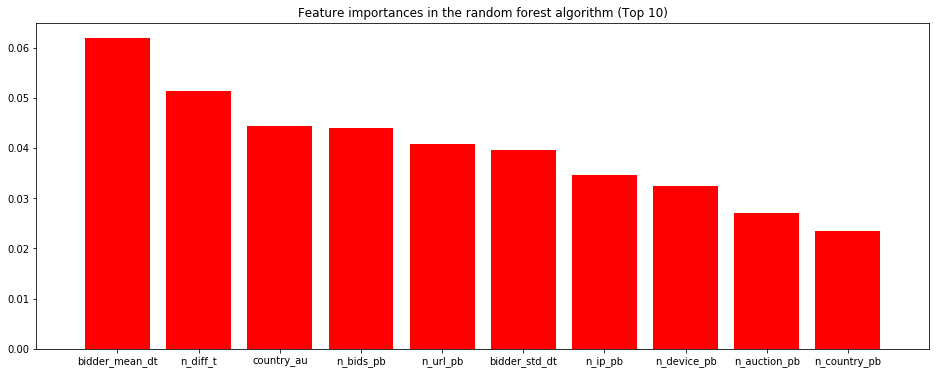

In [17]:
importances = clf_rf.feature_importances_

indices = np.argsort(importances)[::-1]

# Print the feature ranking

n_to_plot = 10 

print ("Feature ranking in the random forest algorithm (top %i):" % n_to_plot)
Features=[]
for f in range(n_to_plot):
    index = indices[f]
    feat = X.columns[index]
    print("%d. feature %s (%f)" % (f + 1, feat, importances[index]))
    Features.append(feat)

# Plot the feature importances of the random forest
plt.figure(figsize=[16,6])
plt.title("Feature importances in the random forest algorithm (Top %i)" % n_to_plot)
plt.bar(range(n_to_plot), importances[indices[0:n_to_plot]],
       color="r", align="center")
plt.xticks(range(n_to_plot), Features)
plt.xlim([-1, n_to_plot])
plt.show()

### Support Vector Machine Prediction (Gaussian kernel)

In [18]:
# Importing sklearn
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

X = train.drop("outcome",axis=1) # Training vectors
y = train["outcome"] # Target values

# As I have only target values (robot:1 - human:0) in train.csv
# I need to keep 20% of these data aside as a testing set 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

X_predict = predict.drop("outcome",axis=1) # Vectors for prediction
bid_id = X_predict.index                   # Used later to print the predictions

# The Imputer is used to fill in the remaining NaN's with means
impt = Imputer(missing_values='NaN', strategy='mean', axis=0)

# To prevent data leakage I fit the imputer to X_train and 
# then use the same parameters for X_test and X_predict 
impt.fit(X_train)
X_train = impt.transform(X_train)
X_test = impt.transform(X_test)
X_predict = impt.transform(X_predict)

# Differently from random forests SVC requires feature scaling
# To prevent data leakage I fit the scaler only to X_train

scaler=StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_predict_scaled = scaler.transform(X_predict)

####### The following commented lines have been used to optimize the SVC parameters
####### This is much faster than random forest (only 2 parameters)

## Parameters to optimize: C and gamma
# search_grid_svc = [{'C': [0.1, 1.0, 2.0, 20.0, 80.0, 100.0, 120.0, 200.0], 
#                 'gamma': [0.0001, 0.001, 0.002, 0.005, 0.008, 0.01, 0.1, 1.0, 5.0, 10.0]}] 

# clf_svc = GridSearchCV(SVC(random_state=0, probability=True), search_grid_svc, cv=4,
#                        scoring='roc_auc')

# clf_svc.fit(X_train_scaled, y_train)


# print "Best parameters set found on traning set:"
# print ""
# print clf_svc.best_params_
# print ""
# print "Grid scores on training set:"
# print ""
# for params, mean_score, scores in clf_svc.grid_scores_:
#     print("%0.3f (+/-%0.03f) for %r"
#             % (mean_score, scores.std() * 2, params))
# print ""


################################################################################

# The classifier
clf_svc = SVC(C=20.0, gamma=0.01, probability=True, random_state=0)
# With the parameters above a got 0.888+-0.046 as best score in the grid search

# Fitting the classifier
clf_svc.fit(X_train_scaled, y_train)

# Printing precision, recall, etc. with respect to the test set 
print "Detailed classification report:"
print ""
print "The model is trained on the training set."
print("The scores are computed on the test set.")
print ""
y_true, y_pred = y_test, clf_svc.predict(X_test_scaled)
print(classification_report(y_true, y_pred))
print ""

# Making prediction
prediction_svc = clf_svc.predict_proba(X_predict_scaled)[:,1]

# formatting it according to the instructions
float_formatter = lambda x: "%.1f" % x            
prediction_svc = map(float_formatter, prediction_svc)     

# and writing it to csv file
submission = pd.DataFrame({
         "bidder_id": bid_id,
         "prediction": prediction_svc
     })
submission.to_csv('final_SVC.csv', index=False)

Detailed classification report:

The model is trained on the training set.
The scores are computed on the test set.

             precision    recall  f1-score   support

        0.0       0.98      0.99      0.99       384
        1.0       0.80      0.47      0.59        17

avg / total       0.97      0.97      0.97       401




## Final remarks

-I tested the random forest and support vector machine algorithms on the robot detection problem. At the level of cross validation random forest scored higher, 0.936+-0.007 vs. 0.888+-0.046 (roc_auc scorer). This is confirmed by the submission to the Kaggle website: I got a private score of 0.90671 (top 40%) for random forest and 0.83073 for SVC. <br>

-In order to further improve these results it could be useful to explore different ML models or build new features. For example, I could try to group IPs by considering parts of it or evaluate how fast a bidder reacts to a bid of a different bidder within the same auction (a robot might be faster and more systematic). <br> 

-I tried to play around with some of the features present in this notebook. For example, by not considering the 200 country features the test scores of both RF nd SVC go up but also the score standard deviations increases by 1 order of magnitude. I still think that it is better to include these features but, considering their large number, we could also consider dropping them in favor of a more efficient model. <br>

-My model tends to have small recall, in particular compared to the precision. It means in practice that when my model labels a bidder as robot, the prediction is very likely to be correct; on the other side the model still misses a few robots and this requires further investigation and improvement.